## IBM Data Science -- Coursera Capstone Project
By: Yash Bhatnagar
_____

In [3]:
#Installing libraries
!pip install geocoder
!pip install geopy
!pip install folium

In [4]:
#Importing libraries
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


### Data Mining

In [5]:
#Pulling the data from web
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_html = requests.get(url).text
soup = BeautifulSoup(wiki_html, 'html.parser')

data = []
for tr in soup.tbody.find_all('tr'):
    for td in tr.find_all('td'):
        data.append(td.get_text().strip())

In [6]:
#Cleaning the data into desired format
postal_code = []
borough = []
for i in range(len(data)):
    postal_code.append(data[i][:3])
    x = data[i].split(data[i][2], 1)
    borough.append(x[1])

#Seperating the data properly
data = pd.DataFrame({'Postal_Code':postal_code,'Borough':borough})
data = data[data['Borough']!='Not assigned']
data['Neighbourhood'] = data["Borough"].str.split("(", n = 1, expand = True)[1]
data['Borough'] = data["Borough"].str.split("(", n = 1, expand = True)[0]
data['Neighbourhood'] = data["Neighbourhood"].str.split(")", n = 1, expand = True)[0]
data['Neighbourhood'] = data['Neighbourhood'].astype(str)
data['Neighbourhood'] = data["Neighbourhood"].str.split(" / ",)
data = data.reset_index()

for i in range(len(data['Neighbourhood'])):
    data['Neighbourhood'][i] = ', '.join(data['Neighbourhood'][i])
        
#Grouping the neighborhoods by postalcode and borough
df=data.groupby(['Postal_Code','Borough'])['Neighbourhood'].apply(', '.join).reset_index()

#### Adding Geospatial coordinates to the data

In [7]:
#Importing csv file with coordiantes
geo = pd.read_csv('Geospatial_Coordinates.csv')

In [8]:
#Cheching the column names present in the dataframe
geo.columns

Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object')

In [9]:
#Changing the column names
geo.columns=['Postal_Code', 'Latitude', 'Longitude']

#Merging to obtain the final dataset
df = pd.merge(df,geo,how='left',on='Postal_Code')

#Removing NULL values
df = df.dropna()

#Checking main data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 104
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Postal_Code    103 non-null    object 
 1   Borough        103 non-null    object 
 2   Neighbourhood  103 non-null    object 
 3   Latitude       103 non-null    float64
 4   Longitude      103 non-null    float64
dtypes: float64(2), object(3)
memory usage: 4.8+ KB


In [10]:
df.head()

,Postal_Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [11]:
df.describe(include='all')

,Postal_Code,Borough,Neighbourhood,Latitude,Longitude
count,103,103,103,103.000000,103.000000
unique,103,22,98,NaN,NaN
top,M4T,North York,Downsview,NaN,NaN
freq,1,20,4,NaN,NaN
mean,NaN,NaN,NaN,43.704608,-79.397153
std,NaN,NaN,NaN,0.052463,0.097146
min,NaN,NaN,NaN,43.602414,-79.615819
25%,NaN,NaN,NaN,43.660567,-79.464763
50%,NaN,NaN,NaN,43.696948,-79.388790
75%,NaN,NaN,NaN,43.745320,-79.340923


In [12]:
df['Borough'].value_counts()

North York                                                      20
Downtown Toronto                                                17
Scarborough                                                     16
Etobicoke                                                       11
Central Toronto                                                  9
West Toronto                                                     6
York                                                             4
East York                                                        4
East Toronto                                                     3
Downtown TorontoStn A PO Boxes25 The Esplanade                   1
3MNorth York                                                     1
4MEast Toronto                                                   1
EtobicokeNorthwest                                               1
6MYork                                                           1
East TorontoBusiness reply mail Processing Centre969 Eastern  

***As North York is the maximum occuring Borough, we will take it for our analysis***

In [13]:
loc = 'North York,Toronto'

#making an instance of Nominatim class
geolocator = Nominatim(user_agent="my_request")

#applying geocode method to get the location
location = geolocator.geocode(loc)

#printing address and coordinates
print(location.address)
print((location.latitude, location.longitude))

latitude_x = location.latitude
longitude_y = location.longitude

North York, Toronto, Golden Horseshoe, Ontario, Canada
(43.7543263, -79.44911696639593)


## &#9658; Map of North York

In [14]:
map_NY = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NY)  
    
map_NY

In [15]:
# Foursquare credentials
# @hidden_cell
CLIENT_ID = '31KLFGUHVKSKXT3KNQC4MK0UFE3FGPXKZXLPTLJDSALRQEOK' # my Foursquare ID
CLIENT_SECRET = 'YSKOFJY1A1TRKIVPNWY2E2LQTF20TUF252GVB3WPY0S5XNXH' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 31KLFGUHVKSKXT3KNQC4MK0UFE3FGPXKZXLPTLJDSALRQEOK
CLIENT_SECRET: YSKOFJY1A1TRKIVPNWY2E2LQTF20TUF252GVB3WPY0S5XNXH


In [16]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [17]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood'],
      dtype='object')

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## &#9658; Nearby Locations

In [19]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
1,Pizza Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.755311,-79.441126
2,Times Square Diner,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",43.751058,-79.455591
3,Domino's Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.753127,-79.450926
4,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690


### Category :--

In [20]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Tim Hortons,Coffee Shop,43.754767,-79.443250
1,Pizza Pizza,Pizza Place,43.755311,-79.441126
2,Times Square Diner,American Restaurant,43.751058,-79.455591
3,Domino's Pizza,Pizza Place,43.753127,-79.450926
4,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690


In [21]:
#Top 5
a=pd.Series(nearby_venues.categories)
a.value_counts()[:5]

Pizza Place                  3
Middle Eastern Restaurant    1
Mediterranean Restaurant     1
American Restaurant          1
Men's Store                  1
Name: categories, dtype: int64

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
# Nearby Venues
NY_Venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawr

In [24]:
NY_Venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
2,"Malvern, Rouge",43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
3,"Malvern, Rouge",43.806686,-79.194353,Bus Stop: 85 & 116,43.802198,-79.199389,Bus Station
4,"Malvern, Rouge",43.806686,-79.194353,Tim Hortons / Esso,43.801863,-79.199296,Coffee Shop
5,"Malvern, Rouge",43.806686,-79.194353,Bella's Lechon,43.801291,-79.198378,Filipino Restaurant
6,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Shamrock Burgers,43.783823,-79.168406,Burger Joint
7,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Ted's Restaurant,43.784468,-79.169200,Breakfast Spot
8,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
9,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Amigo's,43.783749,-79.168691,Breakfast Spot


In [25]:
print('There are {} Unique Categories.'.format(len(NY_Venues['Venue Category'].unique())))

There are 327 Unique Categories.


In [26]:
NY_Venues.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,10,10,10,10,10,10
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,8,8,8,8,8,8
"Bedford Park, Lawrence Manor East",31,31,31,31,31,31
Berczy Park,100,100,100,100,100,100
"Birch Cliff, Cliffside West",8,8,8,8,8,8
"Brockton, Parkdale Village, Exhibition Place",85,85,85,85,85,85
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",27,27,27,27,27,27


<BarContainer object of 96 artists>

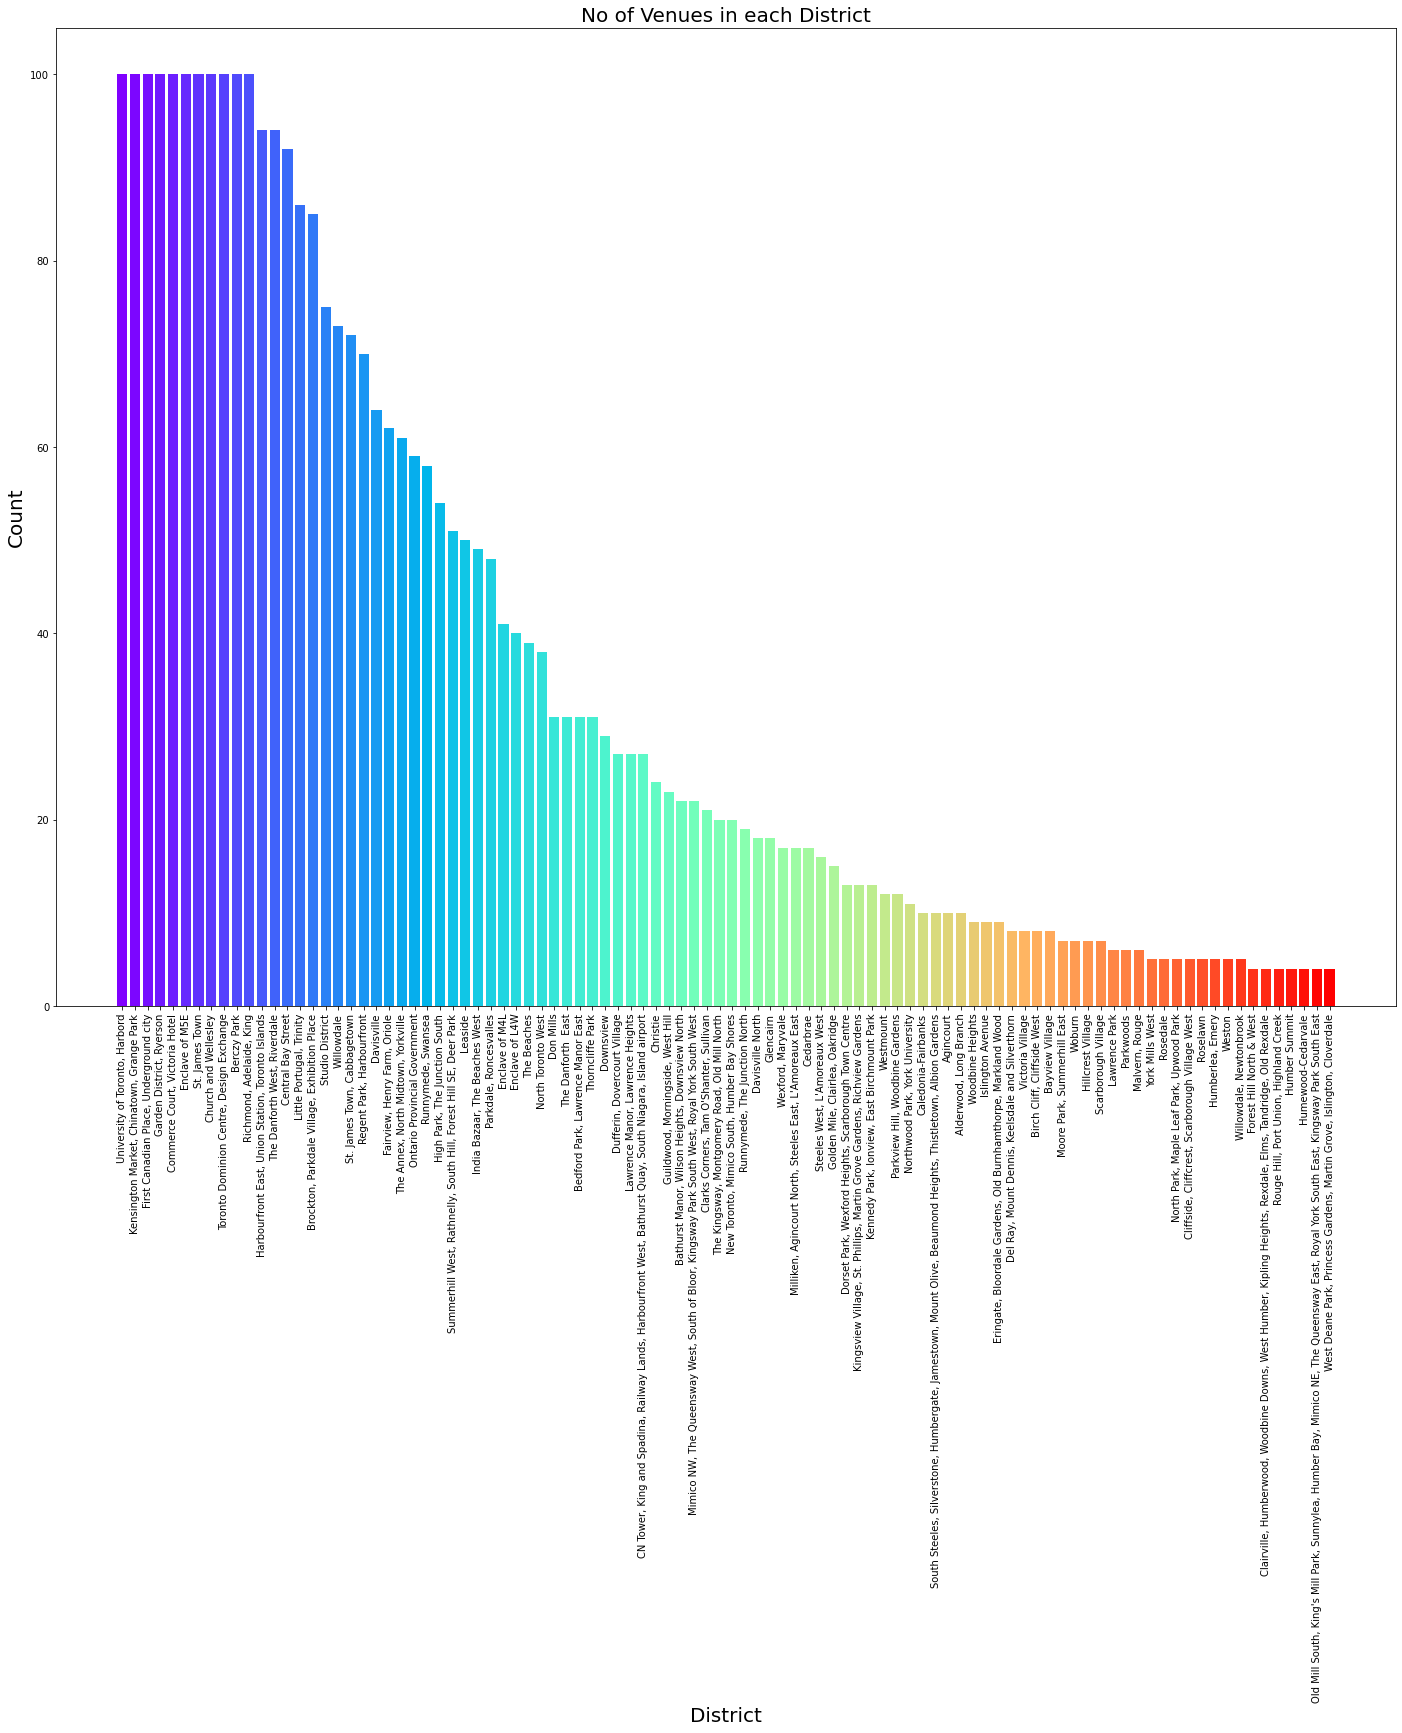

In [77]:
#Graphical representation of the number of venues
no_venues_in_district = NY_Venues.groupby('Neighborhood').count().reset_index()
no_venues_in_district.sort_values('Venue', ascending=False, inplace=True)
venues = no_venues_in_district['Venue']
district = no_venues_in_district['Neighborhood']


colors = cm.rainbow(np.linspace(0, 1, len(venues.index)))
plt.figure(figsize = (24, 18))
plt.xticks(rotation = 90)
plt.xlabel("District", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("No of Venues in each District", fontsize = 20)
plt.bar(district, venues.values, color = colors)

**Type of venues in the desired neighbourhood**

In [74]:
NY_Venues.groupby(['Neighborhood','Venue Category']).count()[['Venue']]

Venue
Neighborhood                                       Venue Category                                 
Agincourt                                          Badminton Court                               1
                                                   Breakfast Spot                                1
                                                   Clothing Store                                1
                                                   Coffee Shop                                   1
                                                   Fabric Shop                                   1
                                                   Latin American Restaurant                     1
                                                   Lounge                                        1
                                                   Motorcycle Shop                               1
                                                   Pool Hall                                     1
                                                   Skating Rink                                  1
Alderwood, Long Branch                             Athletics & Sports                            1
                                                   Coffee Shop                                   1
                                                   Convenience Store                             2
                                                   Gas Station                                   1
                                                   Gym                                           1
                                                   Pizza Place                                   2
                                                   Pub                                           1
                                                   Sandwich Place                                1
Bathurst Manor, Wilson Heights, Downsview North    Bank                                          2
                                                   Bridal Shop                                   1
                                                   Coffee Shop                                   2
                                                   Community Center                              1
                                                   Deli / Bodega                                 1
                                                   Diner                                         1
                                                   Fried Chicken Joint                           1
                                                   Gas Station                                   1
                                                   Ice Cream Shop                                1
                                                   Middle Eastern Restaurant                     1
                                                   Mobile Phone Shop                             1
                                                   Park                                          2
                                                   Pharmacy                                      1
                                                   Pizza Place                                   1
                                                   Restaurant                                    1
                                                   Sandwich Place                                1
                                                   Shopping Mall                                 1
                                                   Supermarket                                   1
                                                   Sushi Restaurant                              1
Bayview Village                                    Bank                                          2
                                                   Café                                          1
                                  

In [84]:
#print unique venue categories
NY_Venues['Venue Category'].value_counts()

Coffee Shop                                 257
Café                                        141
Park                                        102
Restaurant                                   98
Pizza Place                                  90
Sandwich Place                               74
Italian Restaurant                           74
Bakery                                       73
Japanese Restaurant                          69
Hotel                                        60
Grocery Store                                59
Fast Food Restaurant                         54
Gym                                          53
Sushi Restaurant                             53
Bar                                          44
Pharmacy                                     44
Pub                                          43
Gastropub                                    40
Bank                                         40
Thai Restaurant                              38
Breakfast Spot                          

In [85]:
#Total number of neighbourhoods
NY_Venues['Neighborhood'].nunique()

96

________
## Data Preperation for modelling

#### One hot encoding

In [27]:
# one hot encoding
NY_onehot = pd.get_dummies(NY_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Neighbourhood'] = NY_Venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot = NY_onehot[fixed_columns]
NY_grouped = NY_onehot.groupby('Neighbourhood').mean().reset_index()
NY_onehot.head(5)

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pilates Studio,Pizza Place,Plane,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy

In [28]:
num_top_venues = 5
for hood in NY_grouped['Neighbourhood']:
    print("---- "+hood+" ----")
    temp =NY_grouped[NY_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
             venue  freq
0           Lounge   0.1
1      Coffee Shop   0.1
2  Motorcycle Shop   0.1
3      Fabric Shop   0.1
4     Skating Rink   0.1


---- Alderwood, Long Branch ----
               venue  freq
0  Convenience Store   0.2
1        Pizza Place   0.2
2                Pub   0.1
3     Sandwich Place   0.1
4                Gym   0.1


---- Bathurst Manor, Wilson Heights, Downsview North ----
         venue  freq
0         Bank  0.09
1         Park  0.09
2  Coffee Shop  0.09
3  Supermarket  0.05
4  Pizza Place  0.05


---- Bayview Village ----
                 venue  freq
0                 Bank  0.25
1   Chinese Restaurant  0.12
2         Intersection  0.12
3        Grocery Store  0.12
4  Japanese Restaurant  0.12


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Coffee Shop  0.10
1  Italian Restaurant  0.10
2    Sushi Restaurant  0.06
3      Cosmetics Shop  0.06
4      Sandwich Place  0.06


---- Berczy Park ----
       

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Most common venues nearby

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NY_grouped['Neighbourhood']

for ind in np.arange(NY_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NY_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Pool Hall,Coffee Shop,Breakfast Spot,Fabric Shop,Skating Rink,Lounge,Badminton Court,Latin American Restaurant,Clothing Store,Motorcycle Shop
1,"Alderwood, Long Branch",Convenience Store,Pizza Place,Pub,Coffee Shop,Athletics & Sports,Sandwich Place,Gym,Gas Station,Event Space,Fabric Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Coffee Shop,Bank,Pizza Place,Restaurant,Shopping Mall,Diner,Gas Station,Sandwich Place,Sushi Restaurant
3,Bayview Village,Bank,Japanese Restaurant,Café,Playground,Chinese Restaurant,Grocery Store,Intersection,Escape Room,Drugstore,Dry Cleaner
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Cosmetics Shop,Sushi Restaurant,Sandwich Place,Pharmacy,Pizza Place,Liquor Store,Bank,Bakery


## Building K-Means clustering model

In [31]:
# Using K-Means to cluster neighborhood into 3 clusters
NY_grouped_clustering = NY_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(NY_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 2])

In [32]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NY_merged = df[df['Borough']=='North York']

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NY_merged = NY_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

NY_merged.head()# check the last columns!

,Postal_Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.803762,-79.363452,0.0,Fast Food Restaurant,Pharmacy,Tennis Court,Bakery,Sandwich Place,Chinese Restaurant,Restaurant,Doner Restaurant,Donut Shop,Drugstore
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,0.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Juice Bar,Shoe Store,Baseball Field,Cosmetics Shop,Japanese Restaurant,Bakery,Bank
19,M2K,North York,Bayview Village,43.786947,-79.385975,0.0,Bank,Japanese Restaurant,Café,Playground,Chinese Restaurant,Grocery Store,Intersection,Escape Room,Drugstore,Dry Cleaner
20,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,M2N,North York,Willowdale,43.770120,-79.408493,0.0,Coffee Shop,Pizza Place,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Hotel,Middle Eastern Restaurant,Shopping Mall,Café,Bank


In [42]:
NY_merged.dropna(inplace=True)
NY_merged['Cluster Labels'] = NY_merged['Cluster Labels'].astype(int)

## &#9658; Plotting a MAP

In [51]:
kclusters = 10
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NY_merged['Latitude'], 
                                   NY_merged['Longitude'], 
                                   NY_merged['Neighbourhood'], 
                                   NY_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [52]:
df1=NY_merged.loc[NY_merged['Cluster Labels'] == 0,NY_merged.columns[[2] + list(range(5, NY_merged.shape[1]))]]
df2=NY_merged.loc[NY_merged['Cluster Labels'] == 1,NY_merged.columns[[2] + list(range(5, NY_merged.shape[1]))]]
df3=NY_merged.loc[NY_merged['Cluster Labels'] == 2,NY_merged.columns[[2] + list(range(5, NY_merged.shape[1]))]]

## Cluster 1:-

In [53]:
df1

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Hillcrest Village,0,Fast Food Restaurant,Pharmacy,Tennis Court,Bakery,Sandwich Place,Chinese Restaurant,Restaurant,Doner Restaurant,Donut Shop,Drugstore
18,"Fairview, Henry Farm, Oriole",0,Clothing Store,Coffee Shop,Fast Food Restaurant,Juice Bar,Shoe Store,Baseball Field,Cosmetics Shop,Japanese Restaurant,Bakery,Bank
19,Bayview Village,0,Bank,Japanese Restaurant,Café,Playground,Chinese Restaurant,Grocery Store,Intersection,Escape Room,Drugstore,Dry Cleaner
22,Willowdale,0,Coffee Shop,Pizza Place,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Hotel,Middle Eastern Restaurant,Shopping Mall,Café,Bank
24,Willowdale,0,Coffee Shop,Pizza Place,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Hotel,Middle Eastern Restaurant,Shopping Mall,Café,Bank
26,Don Mills,0,Japanese Restaurant,Gym,Restaurant,Sporting Goods Shop,Coffee Shop,Chinese Restaurant,Dim Sum Restaurant,Bike Shop,Discount Store,Supermarket
27,Don Mills,0,Japanese Restaurant,Gym,Restaurant,Sporting Goods Shop,Coffee Shop,Chinese Restaurant,Dim Sum Restaurant,Bike Shop,Discount Store,Supermarket
28,"Bathurst Manor, Wilson Heights, Downsview North",0,Park,Coffee Shop,Bank,Pizza Place,Restaurant,Shopping Mall,Diner,Gas Station,Sandwich Place,Sushi Restaurant
29,"Northwood Park, York University",0,Caribbean Restaurant,Fast Food Restaurant,Miscellaneous Shop,Vietnamese Restaurant,Falafel Restaurant,Pizza Place,Coffee Shop,Metro Station,Bar,Japanese Restaurant
30,Downsview,0,Vietnamese Restaurant,Grocery Store,Sandwich Place,Pizza Place,Pharmacy,Gas Station,Park,Athletics & Sports,Middle Eastern Restaurant,Falafel Restaurant


## Cluster 2:-

In [54]:
df2

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,"North Park, Maple Leaf Park, Upwood Park",1,Home Service,Construction & Landscaping,Park,Bakery,Business Service,Yoga Studio,Escape Room,Drugstore,Dry Cleaner,Dumpling Restaurant
98,Humber Summit,1,Bakery,Home Service,Arts & Crafts Store,Yoga Studio,Escape Room,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant


## Cluster 3:-

In [55]:
df3

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,York Mills West,2,Park,Convenience Store,Tennis Court,Intersection,Yoga Studio,Escape Room,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant
25,Parkwoods,2,Park,Fast Food Restaurant,Food & Drink Shop,Pet Store,Burger Joint,Yoga Studio,Electronics Store,Donut Shop,Drugstore,Dry Cleaner


__________
Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. 